In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [5]:
from reinforcement_example.game import Game

In [6]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

[69.35367927  9.63151013 17.31708383 34.16082832]


KeyboardInterrupt: 

In [19]:
def mean_heatmap(x, y, z, xbins, ybins):
    xi = np.searchsorted(xbins, x)
    yi = np.searchsorted(ybins, y)
    totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
    counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
    for i in range(len(learner.states)):
        totals[xi[i], yi[i]] += z[i]
        counts[xi[i], yi[i]] += 1
    plt.imshow((totals / counts).T,
               origin = 'lower',
               aspect='auto',
               extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))
    plt.colorbar()
    plt.contour(np.linspace(xbins[0], xbins[-1], len(xbins) + 1),
                np.linspace(ybins[0], ybins[-1], len(ybins) + 1),
                (totals / counts).T,
                colors='k')


In [20]:
def show_history(history):
    x = np.zeros(len(history))
    x[1:] = np.cumsum([info[2] for info in history[:-1]])
    y = np.array([info[0][0] for info in history])
    gates = dict()
    for i in range(len(history)):
        gx = x[i] + history[i][0][3]
        gl = history[i][0][1]
        gu = history[i][0][2]
        gates[np.round(gx)] = (gx, gl, gu)
    plt.plot(x, y, '-*')
    for gx, gl, gu in gates.values():
        plt.plot([gx, gx], [0, gl], 'r-')
        plt.plot([gx, gx], [gu, 100], 'r-')

In [7]:
from reinforcement_example.learner import make_model, make_model_elu

In [8]:
from reinforcement_example.learner import AbstractLearner

In [9]:
from reinforcement_example.learner import ScaledModel, ValueToPolicy

In [10]:
from reinforcement_trading.tools import logodds_to_probs, weights_to_inds, random_round

In [11]:
# class SoftPolicy(object):
#     def __init__(self, base, prob_random):
#         self.base = base
#         self.p = prob_random
        
#     def predict(self, states):
#         res = self.base.predict(states)
#         num_actions = res.shape[1]
#         uniform = np.ones(num_actions) / num_actions
#         res = self.p * uniform + (1 - self.p) * res
#         return res

In [12]:
class TDLearner(AbstractLearner):
    def __init__(self, state_dim, num_actions, reward_scale=1.0, model_factory=make_model_elu):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.reward_scale = reward_scale
        self.value_model = [ScaledModel(model_factory(state_dim, 1), yscale=reward_scale) for i in range(num_actions)]
        #self.policy = make_model(state_dim, num_actions)
        self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        self.histories = []
        self.history = []
        # Helper arrays for faster training
        self.states = np.empty((0, self.state_dim))
        self.actions = np.empty(0, dtype=np.int)
        self.rewards = np.empty(0)
        self.logprobs = np.empty(0)
        self.ranges = np.empty((0, 2), dtype=np.int)
        self.actinds = [np.empty(0, dtype=np.int) for i in range(self.num_actions)]

    def move(self, state):
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0])
        choice = np.searchsorted(np.cumsum(probs), np.random.rand())
        self.last_action_prob = probs[choice]
        return choice
    
    def _state_value(self, state):
        action_values = np.array([model.predict(state[np.newaxis, :])[0, 0] for model in self.value_model])
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0, :])
        return np.dot(probs, action_values)

    def learn(self, state, action, reward, next_state, value_proxy):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward + self._state_value(next_state)]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))

    def learn_last(self, state, action, reward):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        self.histories.append(self.history)
        self.history = []
        self._update_value_model()

    def _update_value_model(self):
        # Update data structures
        dsize = len(self.states)
        for i in range(len(self.ranges), len(self.histories)):
            last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[i][::-1])
            self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
            dsize += len(last_states)
            self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
            self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
            self.rewards = np.concatenate([self.rewards, last_rewards])
            #self.logprobs = np.concatenate([self.logprobs, [0], np.log(last_actionprob)[:-1]])
            #self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
            self.actinds = [np.concatenate([self.actinds[i],
                                            np.arange(dsize - len(last_states), dsize)
                                                [self.actions[dsize - len(last_states):dsize] == i]])
                            for i in range(self.num_actions)]
        # Training
        policy_probs = logodds_to_probs(self.policy.predict(self.states))
        #policy_logprobs = np.log(policy_probs[np.arange(dsize), self.actions])
        #policy_cumlogprobs = np.zeros(dsize)
        #for start, end in self.ranges:
        #    policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        predicted_state_action_value = np.array([model.predict(self.states)[:, 0] for model in self.value_model]).T
        predicted_state_value = np.sum(policy_probs * predicted_state_action_value, axis=1)
        response = np.empty(self.rewards.shape)
        response[:] = self.rewards
        for start, end in self.ranges:
            response[start + 1:end] += predicted_state_value[start:end - 1]
        predicted_value = predicted_state_action_value[np.arange(dsize), self.actions]
        # weights = np.exp(policy_logprobs - self.logprobs)
        for action in range(self.num_actions):
            inds = self.actinds[action]  #[weights_to_inds(weights[self.actinds[action]])]
            if len(inds) > 0:
                self.value_model[action].fit(self.states[inds, :], response[inds],
                                             epochs=10#,
                                             #callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=2)]
                                            )
        # Policy scale
        #mse = np.dot(weights, (predicted_value - response) ** 2) / np.sum(weights)
        #self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        self.policy.set_scale(self.reward_scale / np.sqrt(len(self.histories)))
        return


In [13]:
from reinforcement_example.learner import train_play

In [ ]:
game = Game()
learner = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)

In [ ]:
learner2 = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)
learner2.histories = learner.histories
learner2.value_model = learner.value_model
learner2._update_value_model()
learner_bak = learner
learner = learner2


In [ ]:
for i in range(10):
    learner._update_value_model()

In [ ]:
fooh, foor = train_play(Game(), learner)
show_history(fooh)
plt.grid(True)
foor

In [ ]:
fooh[-1]

In [ ]:
history = []

In [ ]:
for i in range(10000):
    history.append(train_play(Game(), learner)[1])
    if len(history) % 100 == 0:
        print(len(history))
    if os.path.exists("002_reinforcement_example_v5_stop"):
        break
plt.plot(np.cumsum(history))

In [ ]:
plt.plot(np.cumsum(history))

In [ ]:
for i in range(100):
    history.append(train_play(Game(), learner)[1])
plt.plot(np.cumsum(history))

In [ ]:
np.mean(history)

In [ ]:
len(history)

In [ ]:
# import pickle
# with open('002_reinforcement_example_v2_learner.pickle', 'wb') as f:
#     pickle.dump({
#         'histories': learner.histories,
#         'value_model': [
#             {
#                 'config': model.get_config(),
#                 'weights': model.get_weights()
#             }
#             for model in learner.value_model
#         ]
#     }, f)

In [ ]:
import pickle
with open('002_reinforcement_example_v5_learner_v3.pickle', 'wb') as f:
    pickle.dump(dict([(foo, learner.__dict__[foo]) for foo in learner.__dict__
                      if foo != "value_model" and foo != 'policy'] +
                     [("value_model", [{
                         "xscale": model.xscale,
                         "yscale": model.yscale,
                         "config": model.model.get_config(),
                         "weights": model.model.get_weights()
                     } for model in learner.value_model])]), f)

In [ ]:
plt.plot(np.sort(learner.rewards))

In [ ]:
foo = np.zeros((100, 4))
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy0 = learner.value_model[0].predict(foo).reshape(-1)
fooy1 = learner.value_model[1].predict(foo).reshape(-1)
plt.plot(foo[:, 3], fooy0, '.')
plt.plot(foo[:, 3], fooy1, '.')
plt.grid()

In [ ]:
np.min(learner.rewards)

In [ ]:
        cumrewards = np.empty(len(learner.states))
        for start, end in learner.ranges:
            cumrewards[start:end] = np.cumsum(learner.rewards[start:end])
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.plot(X[:, 3], Y, '.')
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.figure()
            plt.plot(learner.value_model[action].predict(X), Y, '.')
            #plt.title('Prediction vs response, RMS = {}'.format(learner.value_model[action].evaluate(X[inds], Y[inds])))
            plt.grid(True)

In [ ]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

In [ ]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

In [ ]:
learner.policy.scale

In [ ]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += learner.cumrewards[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [ ]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [ ]:
def mean_heatmap(x, y, z, xbins, ybins):
    xi = np.searchsorted(xbins, x)
    yi = np.searchsorted(ybins, y)
    totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
    counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
    for i in range(len(learner.states)):
        totals[xi[i], yi[i]] += z[i]
        counts[xi[i], yi[i]] += 1
    plt.imshow((totals / counts).T,
               origin = 'lower',
               aspect='auto',
               extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))
    plt.colorbar()
    plt.contour(np.linspace(xbins[0], xbins[-1], len(xbins) + 1),
                np.linspace(ybins[0], ybins[-1], len(ybins) + 1),
                (totals / counts).T,
                colors='k')


In [ ]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
for action in range(learner.num_actions):
    predictions = learner.value_model[action].predict(learner.states).reshape(-1)
    plt.figure()
    mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

predictions = logodds_to_probs(learner.policy.predict(learner.states))[:, 1]
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

In [ ]:
np.min(predictions), np.max(predictions)

In [ ]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
plt.plot(-learner.states[:, 3], dy, '.')

## Test the ability of the neural network to learn...

In [ ]:
model = make_model(6, 1)

In [ ]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [ ]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

In [ ]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)

### Fix a policy, only learn the value functions

In [14]:
game = Game()
learner = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)

In [16]:
class RandomPolicy(object):
    def __init__(self, numactions):
        self.numactions = numactions
    def predict(self, states):
        return np.zeros((len(states), self.numactions))
    def set_scale(self, scale):
        # Ignore
        pass

In [17]:
learner.policy = RandomPolicy(learner.num_actions)

#### Train

In [38]:
for i in range(100):
    train_play(Game(), learner)


Epoch 1/10
6361/6361 [==============================] - 0s 58us/step - loss: 0.0022
Epoch 2/10
6361/6361 [==============================] - 0s 66us/step - loss: 0.0023
Epoch 3/10
6361/6361 [==============================] - 0s 55us/step - loss: 0.0022
Epoch 4/10
6361/6361 [==============================] - 0s 68us/step - loss: 0.0022
Epoch 5/10
6361/6361 [==============================] - 0s 71us/step - loss: 0.0022
Epoch 6/10
6361/6361 [==============================] - 0s 60us/step - loss: 0.0022
Epoch 7/10
6361/6361 [==============================] - 0s 60us/step - loss: 0.0022
Epoch 8/10
6361/6361 [==============================] - 0s 73us/step - loss: 0.0022
Epoch 9/10
6361/6361 [==============================] - 0s 76us/step - loss: 0.0022
Epoch 10/10
6361/6361 [==============================] - 1s 87us/step - loss: 0.0022
Epoch 1/10
6364/6364 [==============================] - 1s 82us/step - loss: 0.0014
Epoch 2/10
6364/6364 [==============================] - 1s 80us/step - loss

6454/6454 [==============================] - 0s 63us/step - loss: 0.0015
Epoch 9/10
6454/6454 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 10/10
6454/6454 [==============================] - 0s 67us/step - loss: 0.0014
Epoch 1/10
6477/6477 [==============================] - 0s 52us/step - loss: 0.0025
Epoch 2/10
6477/6477 [==============================] - 0s 64us/step - loss: 0.0024
Epoch 3/10
6477/6477 [==============================] - 0s 55us/step - loss: 0.0024
Epoch 4/10
6477/6477 [==============================] - 0s 60us/step - loss: 0.0024
Epoch 5/10
6477/6477 [==============================] - 0s 55us/step - loss: 0.0024
Epoch 6/10
6477/6477 [==============================] - 0s 56us/step - loss: 0.0024
Epoch 7/10
6477/6477 [==============================] - 0s 70us/step - loss: 0.0024
Epoch 8/10
6477/6477 [==============================] - 0s 57us/step - loss: 0.0024
Epoch 9/10
6477/6477 [==============================] - 0s 56us/step - loss: 0.0024
Ep

6546/6546 [==============================] - 0s 67us/step - loss: 0.0015
Epoch 6/10
6546/6546 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 7/10
6546/6546 [==============================] - 0s 69us/step - loss: 0.0014
Epoch 8/10
6546/6546 [==============================] - 1s 78us/step - loss: 0.0014
Epoch 9/10
6546/6546 [==============================] - 1s 88us/step - loss: 0.0014
Epoch 10/10
6546/6546 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 1/10
6572/6572 [==============================] - 1s 77us/step - loss: 0.0023
Epoch 2/10
6572/6572 [==============================] - 0s 52us/step - loss: 0.0024
Epoch 3/10
6572/6572 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 4/10
6572/6572 [==============================] - 0s 52us/step - loss: 0.0023
Epoch 5/10
6572/6572 [==============================] - 0s 54us/step - loss: 0.0024
Epoch 6/10
6572/6572 [==============================] - 0s 53us/step - loss: 0.0023
Ep

6694/6694 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 3/10
6694/6694 [==============================] - 0s 65us/step - loss: 0.0016
Epoch 4/10
6694/6694 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 5/10
6694/6694 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 6/10
6694/6694 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 7/10
6694/6694 [==============================] - 0s 51us/step - loss: 0.0016
Epoch 8/10
6694/6694 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 9/10
6694/6694 [==============================] - 0s 59us/step - loss: 0.0015
Epoch 10/10
6694/6694 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 1/10
6710/6710 [==============================] - 0s 52us/step - loss: 0.0026
Epoch 2/10
6710/6710 [==============================] - 0s 64us/step - loss: 0.0025
Epoch 3/10
6710/6710 [==============================] - 0s 51us/step - loss: 0.0026
Ep

6799/6799 [==============================] - 0s 56us/step - loss: 0.0025
Epoch 10/10
6799/6799 [==============================] - 0s 52us/step - loss: 0.0025
Epoch 1/10
6798/6798 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 2/10
6798/6798 [==============================] - 0s 66us/step - loss: 0.0015
Epoch 3/10
6798/6798 [==============================] - 1s 78us/step - loss: 0.0015
Epoch 4/10
6798/6798 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 5/10
6798/6798 [==============================] - 1s 79us/step - loss: 0.0015
Epoch 6/10
6798/6798 [==============================] - 0s 69us/step - loss: 0.0015
Epoch 7/10
6798/6798 [==============================] - 0s 61us/step - loss: 0.0015
Epoch 8/10
6798/6798 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 9/10
6798/6798 [==============================] - 0s 70us/step - loss: 0.0015
Epoch 10/10
6798/6798 [==============================] - 0s 58us/step - loss: 0.0015
E

6906/6906 [==============================] - 0s 63us/step - loss: 0.0024
Epoch 7/10
6906/6906 [==============================] - 0s 65us/step - loss: 0.0024
Epoch 8/10
6906/6906 [==============================] - 0s 59us/step - loss: 0.0024
Epoch 9/10
6906/6906 [==============================] - 0s 59us/step - loss: 0.0024
Epoch 10/10
6906/6906 [==============================] - 0s 70us/step - loss: 0.0024
Epoch 1/10
6934/6934 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 2/10
6934/6934 [==============================] - 0s 59us/step - loss: 0.0015
Epoch 3/10
6934/6934 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 4/10
6934/6934 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 5/10
6934/6934 [==============================] - 1s 79us/step - loss: 0.0015
Epoch 6/10
6934/6934 [==============================] - 1s 106us/step - loss: 0.0015
Epoch 7/10
6934/6934 [==============================] - 1s 76us/step - loss: 0.0015
E

7009/7009 [==============================] - 0s 60us/step - loss: 0.0024
Epoch 4/10
7009/7009 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 5/10
7009/7009 [==============================] - 0s 54us/step - loss: 0.0023
Epoch 6/10
7009/7009 [==============================] - 1s 78us/step - loss: 0.0023
Epoch 7/10
7009/7009 [==============================] - 0s 69us/step - loss: 0.0023
Epoch 8/10
7009/7009 [==============================] - 1s 90us/step - loss: 0.0023
Epoch 9/10
7009/7009 [==============================] - 0s 57us/step - loss: 0.0023
Epoch 10/10
7009/7009 [==============================] - 0s 70us/step - loss: 0.0023
Epoch 1/10
7030/7030 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 2/10
7030/7030 [==============================] - 0s 65us/step - loss: 0.0016
Epoch 3/10
7030/7030 [==============================] - 0s 58us/step - loss: 0.0016
Epoch 4/10
7030/7030 [==============================] - 0s 61us/step - loss: 0.0016: 0

7120/7120 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 1/10
7104/7104 [==============================] - 0s 61us/step - loss: 0.0022
Epoch 2/10
7104/7104 [==============================] - 0s 57us/step - loss: 0.0022
Epoch 3/10
7104/7104 [==============================] - 0s 55us/step - loss: 0.0022
Epoch 4/10
7104/7104 [==============================] - 0s 57us/step - loss: 0.0022
Epoch 5/10
7104/7104 [==============================] - 0s 57us/step - loss: 0.0022 ETA: 0s - loss: 0.0034    - ETA: 0s - loss: 
Epoch 6/10
7104/7104 [==============================] - 0s 63us/step - loss: 0.0022
Epoch 7/10
7104/7104 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 8/10
7104/7104 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 9/10
7104/7104 [==============================] - 0s 57us/step - loss: 0.0022
Epoch 10/10
7104/7104 [==============================] - 0s 54us/step - loss: 0.0022
Epoch 1/10
7132/7132 [===================

7234/7234 [==============================] - 0s 58us/step - loss: 0.0014
Epoch 7/10
7234/7234 [==============================] - 0s 54us/step - loss: 0.0014
Epoch 8/10
7234/7234 [==============================] - 0s 64us/step - loss: 0.0014
Epoch 9/10
7234/7234 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 10/10
7234/7234 [==============================] - 0s 40us/step - loss: 0.0014
Epoch 1/10
7248/7248 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 2/10
7248/7248 [==============================] - 0s 63us/step - loss: 0.0022
Epoch 3/10
7248/7248 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 4/10
7248/7248 [==============================] - 0s 61us/step - loss: 0.0022
Epoch 5/10
7248/7248 [==============================] - 0s 55us/step - loss: 0.0022
Epoch 6/10
7248/7248 [==============================] - 0s 67us/step - loss: 0.0021
Epoch 7/10
7248/7248 [==============================] - 0s 53us/step - loss: 0.0022
Ep

7355/7355 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 4/10
7355/7355 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 5/10
7355/7355 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 6/10
7355/7355 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 7/10
7355/7355 [==============================] - 0s 62us/step - loss: 0.0014
Epoch 8/10
7355/7355 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 9/10
7355/7355 [==============================] - 0s 60us/step - loss: 0.0014
Epoch 10/10
7355/7355 [==============================] - 0s 54us/step - loss: 0.0013
Epoch 1/10
7340/7340 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 2/10
7340/7340 [==============================] - 0s 56us/step - loss: 0.0022
Epoch 3/10
7340/7340 [==============================] - 0s 53us/step - loss: 0.0022
Epoch 4/10
7340/7340 [==============================] - 0s 63us/step - loss: 0.0022
Ep

7437/7437 [==============================] - 0s 59us/step - loss: 0.0022
Epoch 1/10
7481/7481 [==============================] - 0s 58us/step - loss: 0.0014
Epoch 2/10
7481/7481 [==============================] - 0s 49us/step - loss: 0.0014
Epoch 3/10
7481/7481 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 4/10
7481/7481 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 5/10
7481/7481 [==============================] - 0s 51us/step - loss: 0.0014
Epoch 6/10
7481/7481 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 7/10
7481/7481 [==============================] - 1s 74us/step - loss: 0.0014
Epoch 8/10
7481/7481 [==============================] - 1s 75us/step - loss: 0.0014
Epoch 9/10
7481/7481 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 10/10
7481/7481 [==============================] - 0s 49us/step - loss: 0.0014
Epoch 1/10
7479/7479 [==============================] - 0s 57us/step - loss: 0.0022
Ep

7531/7531 [==============================] - 0s 55us/step - loss: 0.0021
Epoch 8/10
7531/7531 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 9/10
7531/7531 [==============================] - 0s 58us/step - loss: 0.0021
Epoch 10/10
7531/7531 [==============================] - 0s 47us/step - loss: 0.0020
Epoch 1/10
7576/7576 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 2/10
7576/7576 [==============================] - 0s 55us/step - loss: 0.0013
Epoch 3/10
7576/7576 [==============================] - 0s 49us/step - loss: 0.0013
Epoch 4/10
7576/7576 [==============================] - 0s 56us/step - loss: 0.0013
Epoch 5/10
7576/7576 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 6/10
7576/7576 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 7/10
7576/7576 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 8/10
7576/7576 [==============================] - 0s 50us/step - loss: 0.0013
Ep

7644/7644 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 5/10
7644/7644 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 6/10
7644/7644 [==============================] - 0s 47us/step - loss: 0.0021
Epoch 7/10
7644/7644 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 8/10
7644/7644 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 9/10
7644/7644 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 10/10
7644/7644 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 1/10
7685/7685 [==============================] - 0s 50us/step - loss: 0.0012
Epoch 2/10
7685/7685 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 3/10
7685/7685 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 4/10
7685/7685 [==============================] - 0s 48us/step - loss: 0.0012
Epoch 5/10
7685/7685 [==============================] - 0s 59us/step - loss: 0.0012
Ep

7812/7812 [==============================] - 0s 47us/step - loss: 0.0021
Epoch 2/10
7812/7812 [==============================] - 0s 50us/step - loss: 0.0021
Epoch 3/10
7812/7812 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 4/10
7812/7812 [==============================] - 0s 58us/step - loss: 0.0021
Epoch 5/10
7812/7812 [==============================] - 0s 50us/step - loss: 0.0021
Epoch 6/10
7812/7812 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 7/10
7812/7812 [==============================] - 0s 56us/step - loss: 0.0021
Epoch 8/10
7812/7812 [==============================] - 0s 53us/step - loss: 0.0021
Epoch 9/10
7812/7812 [==============================] - 0s 57us/step - loss: 0.0021
Epoch 10/10
7812/7812 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 1/10
7845/7845 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 2/10
7845/7845 [==============================] - 0s 51us/step - loss: 0.0013
Ep

7919/7919 [==============================] - 0s 56us/step - loss: 0.0013
Epoch 9/10
7919/7919 [==============================] - 0s 46us/step - loss: 0.0013
Epoch 10/10
7919/7919 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 1/10
7920/7920 [==============================] - 0s 57us/step - loss: 0.0020
Epoch 2/10
7920/7920 [==============================] - 0s 49us/step - loss: 0.0020
Epoch 3/10
7920/7920 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 4/10
7920/7920 [==============================] - 0s 61us/step - loss: 0.0020
Epoch 5/10
7920/7920 [==============================] - 1s 75us/step - loss: 0.0020
Epoch 6/10
7920/7920 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 7/10
7920/7920 [==============================] - 0s 60us/step - loss: 0.0020
Epoch 8/10
7920/7920 [==============================] - 1s 64us/step - loss: 0.0020
Epoch 9/10
7920/7920 [==============================] - 1s 66us/step - loss: 0.0020
Ep

8029/8029 [==============================] - 0s 48us/step - loss: 0.0013
Epoch 6/10
8029/8029 [==============================] - 0s 47us/step - loss: 0.0013
Epoch 7/10
8029/8029 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 8/10
8029/8029 [==============================] - 0s 49us/step - loss: 0.0013
Epoch 9/10
8029/8029 [==============================] - 0s 59us/step - loss: 0.0013
Epoch 10/10
8029/8029 [==============================] - 0s 49us/step - loss: 0.0013
Epoch 1/10
8040/8040 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 2/10
8040/8040 [==============================] - 0s 60us/step - loss: 0.0020
Epoch 3/10
8040/8040 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 4/10
8040/8040 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 5/10
8040/8040 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 6/10
8040/8040 [==============================] - 0s 57us/step - loss: 0.0020
Ep

8195/8195 [==============================] - 0s 61us/step - loss: 0.0012
Epoch 3/10
8195/8195 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 4/10
8195/8195 [==============================] - 0s 58us/step - loss: 0.0012
Epoch 5/10
8195/8195 [==============================] - 0s 54us/step - loss: 0.0012
Epoch 6/10
8195/8195 [==============================] - 0s 56us/step - loss: 0.0012
Epoch 7/10
8195/8195 [==============================] - 1s 79us/step - loss: 0.0012
Epoch 8/10
8195/8195 [==============================] - 1s 63us/step - loss: 0.0012
Epoch 9/10
8195/8195 [==============================] - 0s 61us/step - loss: 0.0012
Epoch 10/10
8195/8195 [==============================] - 1s 66us/step - loss: 0.0012
Epoch 1/10
8220/8220 [==============================] - 0s 54us/step - loss: 0.0020
Epoch 2/10
8220/8220 [==============================] - 0s 60us/step - loss: 0.0020
Epoch 3/10
8220/8220 [==============================] - 0s 57us/step - loss: 0.0020
Ep

8280/8280 [==============================] - 1s 64us/step - loss: 0.0019
Epoch 10/10
8280/8280 [==============================] - 1s 82us/step - loss: 0.0019
Epoch 1/10
8282/8282 [==============================] - 1s 71us/step - loss: 0.0013
Epoch 2/10
8282/8282 [==============================] - 0s 53us/step - loss: 0.0012
Epoch 3/10
8282/8282 [==============================] - 0s 59us/step - loss: 0.0012
Epoch 4/10
8282/8282 [==============================] - 0s 44us/step - loss: 0.0012
Epoch 5/10
8282/8282 [==============================] - 0s 52us/step - loss: 0.0012
Epoch 6/10
8282/8282 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 7/10
8282/8282 [==============================] - 0s 49us/step - loss: 0.0012
Epoch 8/10
8282/8282 [==============================] - 0s 58us/step - loss: 0.0012
Epoch 9/10
8282/8282 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 10/10
8282/8282 [==============================] - 0s 55us/step - loss: 0.0012
E

8371/8371 [==============================] - 0s 53us/step - loss: 0.0019
Epoch 7/10
8371/8371 [==============================] - 0s 50us/step - loss: 0.0018
Epoch 8/10
8371/8371 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 9/10
8371/8371 [==============================] - 0s 48us/step - loss: 0.0019
Epoch 10/10
8371/8371 [==============================] - 0s 54us/step - loss: 0.0019
Epoch 1/10
8373/8373 [==============================] - 0s 55us/step - loss: 0.0012
Epoch 2/10
8373/8373 [==============================] - 0s 55us/step - loss: 0.0012
Epoch 3/10
8373/8373 [==============================] - 0s 58us/step - loss: 0.0012
Epoch 4/10
8373/8373 [==============================] - 0s 57us/step - loss: 0.0012
Epoch 5/10
8373/8373 [==============================] - 0s 57us/step - loss: 0.0012
Epoch 6/10
8373/8373 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 7/10
8373/8373 [==============================] - 0s 48us/step - loss: 0.0012
Ep

8464/8464 [==============================] - 0s 49us/step - loss: 0.0020
Epoch 4/10
8464/8464 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 5/10
8464/8464 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 6/10
8464/8464 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 7/10
8464/8464 [==============================] - 0s 55us/step - loss: 0.0020
Epoch 8/10
8464/8464 [==============================] - 0s 49us/step - loss: 0.0020
Epoch 9/10
8464/8464 [==============================] - 0s 55us/step - loss: 0.0020
Epoch 10/10
8464/8464 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 1/10
8483/8483 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 2/10
8483/8483 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 3/10
8483/8483 [==============================] - 0s 49us/step - loss: 0.0013
Epoch 4/10
8483/8483 [==============================] - 0s 53us/step - loss: 0.0013
Ep

8542/8542 [==============================] - 0s 56us/step - loss: 0.0013
Epoch 1/10
8571/8571 [==============================] - 0s 50us/step - loss: 0.0021
Epoch 2/10
8571/8571 [==============================] - 0s 53us/step - loss: 0.0021
Epoch 3/10
8571/8571 [==============================] - 0s 49us/step - loss: 0.0021
Epoch 4/10
8571/8571 [==============================] - 0s 55us/step - loss: 0.0020
Epoch 5/10
8571/8571 [==============================] - 0s 53us/step - loss: 0.0020
Epoch 6/10
8571/8571 [==============================] - 0s 52us/step - loss: 0.0020
Epoch 7/10
8571/8571 [==============================] - 0s 46us/step - loss: 0.0020
Epoch 8/10
8571/8571 [==============================] - 0s 51us/step - loss: 0.0020
Epoch 9/10
8571/8571 [==============================] - 1s 60us/step - loss: 0.0021
Epoch 10/10
8571/8571 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 1/10
8561/8561 [==============================] - 0s 54us/step - loss: 0.0013
Ep

#### Analysis

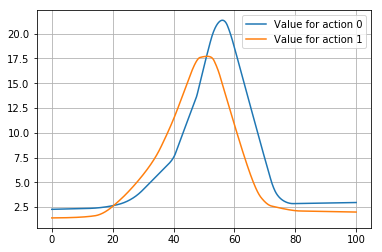

In [39]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

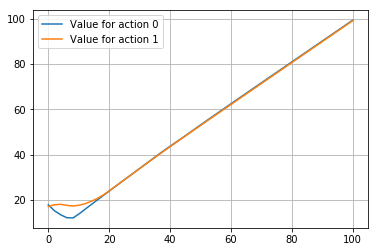

In [40]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


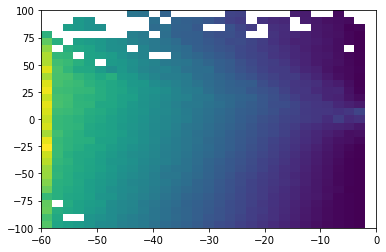

In [41]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/lib64/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


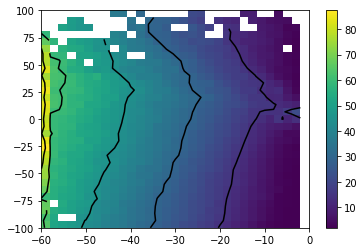

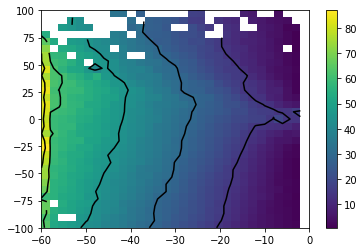

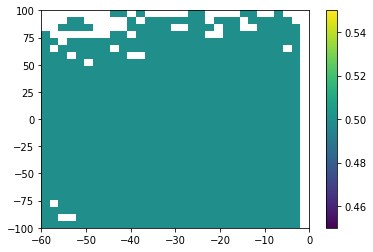

In [42]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
for action in range(learner.num_actions):
    predictions = learner.value_model[action].predict(learner.states).reshape(-1)
    plt.figure()
    mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

predictions = logodds_to_probs(learner.policy.predict(learner.states))[:, 1]
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


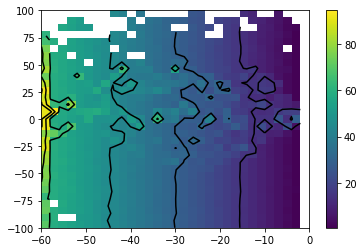

In [43]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
cumrewards = np.empty(len(learner.rewards))
for start, end in learner.ranges:
    cumrewards[start:end] = np.cumsum(learner.rewards[start:end])
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, cumrewards, xbins, ybins)